In [2]:
from __future__ import division
import gensim
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
import re
from textblob import TextBlob
from polyglot.text import Text
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from textblob.sentiments import NaiveBayesAnalyzer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score, recall_score,precision_score , confusion_matrix, roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import KFold
import ftfy
%matplotlib inline 

#Exploratory Data Analysis (EDA)

In [3]:
enron = pd.read_csv("energy_bids.csv")

In [4]:
enron.head()

,email,responsive
0,North America's integrated electricity market ...,0
1,"FYI -----Original Message----- From: \t""Ginny ...",1
2,"14:13:53 Synchronizing Mailbox 'Kean, Steven J...",0
3,^ ----- Forwarded by Steven J Kean/NA/Enron on...,1
4,----- Forwarded by Steven J Kean/NA/Enron on 0...,0


###What specific munging issues do you have to address (e.g., encoding, missing data, or data to exclude)?

The data was not structurally organized.  There were lots of issues with unicode which interfered with data analysis.  There was quite a bit of clean to be done and I read a document called working with text in pandas. 

###Tokenization

I used the nltk tokenizer and it didn't is two words. I combined all the emails in a big bag of words and I used that to do frequency counts.  I used the stopword function, but I created a list of my own because there were other words that were surfacing that did not contribute to many meaning.   

###Normalization

I wanted to use a semmer, but I always run into unicode issues so I am not able to process the whole entire text with it

###Tagging
I used pos tagging, but I am not sure what to do with that knowledge.

###Topic Modeling

I thought the topics that were generate were a little bit redundant.  I had a difficult time creating a topic based on the words.  

###Predictive Model

I chose to use Naive Bayes because not only did it give strong predictions, because it uses the probability of a feature given a class to see if the email is relevant or not.  Emails with stronger word features has a higher probability, which is more likely to became a 1 and the others were 0.  It was able to handle the noise and the irrelevant features without affecting results.

Another good classifier would be Logistic Regression.

###Validation

I did a train/test split and a K-Folds 20 times to see the consistency of the model prodictions.  

###Scoring

I used F1, Precision, and Recall to score the results.  I also have an ROC curve

###Ensemble and/or Boosted Models: 

I tried the SGDClassifier which produced very good results, but I chose to stick with NB because it is fast and comparatively simple compared a gradient.  

In [4]:
clean_enron = pd.Series(enron['email'])

In [5]:
responsive = enron[enron['responsive'] == 1]
not_responsive = enron[enron['responsive'] == 0]

In [6]:
clean_enron = clean_enron.str.replace('[,|<|>|"|.|?|*|-|!|#|$|&|''|\|/|^|(|)|:|;|_|-|+|=|`|~{|}|\t|[|]|]\'s', '')
clean_enron = clean_enron.str.replace("\\", '')
clean_enron = clean_enron.str.replace("'", '')
clean_enron = clean_enron.str.replace("-", '')
clean_enron1 = clean_enron.str.lower()
cleaned_enron = reduce(lambda a,b:a+b,clean_enron1) #Lee Murphy helped me on this one
clean_enron = nltk.word_tokenize(cleaned_enron)

In [7]:
nltk.word_tokenize("didn't")

['did', "n't"]

In [8]:
stop = stopwords.words('english')

useless_words = ['to:','subject:','pm','cc:','would','please',
                 'said','know','(email)"', 'xcb\x9c', 'need', '%',
                 'us','email','re:', 'since', 'take','back', 
                 'inc','make','let','last','*','may','\xcb\x9c','&'
                 ,'thanks','to:','still','also','forwarded','attached', 'sent'
                'get','2','could','from:','draft','message','j','1',
                 'forward','one', 'like', 'use', 'per','day', 'see', "@",
                 'subject' ,'cc', '141407' ,'ect' , 'enroncom' , ']' , 're','new','two','said' ,'call', 'get', 'sent']

In [9]:
no_stop_words = []
for i in clean_enron:
    if i not in stop + useless_words:
        no_stop_words.append(i)

/Users/user/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


In [10]:
dd = Counter(no_stop_words).most_common(20)
dd

[('enron', 2254),
 ('power', 1182),
 ('gas', 834),
 ('market', 822),
 ('energy', 781),
 ('california', 665),
 ('electricity', 544),
 ('price', 537),
 ('state', 448),
 ('information', 411),
 ('2001', 406),
 ('prices', 391),
 ('time', 368),
 ('2000', 354),
 ('ees', 346),
 ('agreement', 326),
 ('ferc', 325),
 ('company', 308),
 ('trading', 308),
 ('utilities', 271)]

In [11]:
values = [dd[i][1] for i in range(len(dd))]
keys = [dd[i][0] for i in range(len(dd))]


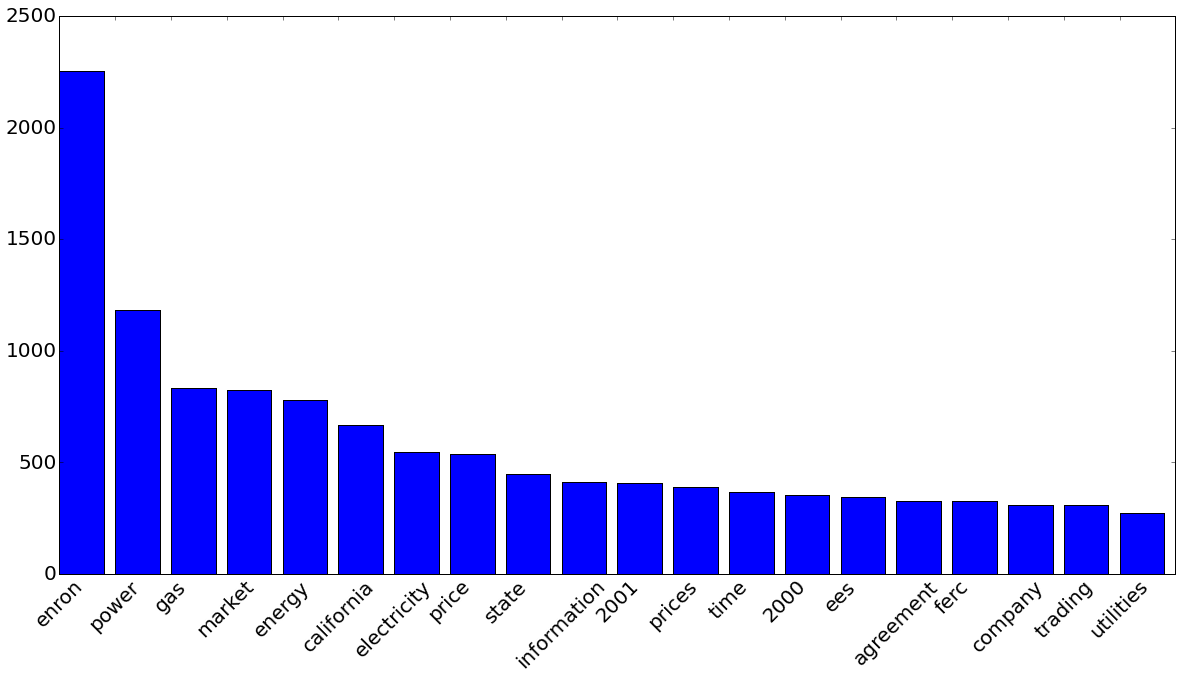

In [12]:
plt.figure(figsize=(20,10))
plt.bar(range(len(values)), values)
plt.xticks(range(len(keys)), keys, size = 20 , rotation=45)
plt.yticks(size = 20)
plt.show()

In [13]:
text = Text(str(clean_enron))

In [14]:
NER = text.entities

In [15]:
pos_tag = nltk.pos_tag(no_stop_words)

In [16]:
d = {'I-PER':[],'I-LOC':[],'I-ORG':[]}

for entity in NER:
    if entity.tag == "I-PER":
        d['I-PER'].append(str(entity))
    if entity.tag == 'I-LOC':
        d['I-LOC'].append(str(entity))
    if entity.tag == 'I-ORG':
        d['I-ORG'].append(str(entity))      

In [17]:
d['I-PER'] = Counter(d['I-PER']).most_common(20)
d['I-LOC'] = Counter(d['I-LOC']).most_common(20)
d['I-ORG'] = Counter(d['I-ORG']).most_common(20)

In [18]:
Per_numbers = [d['I-PER'][i][1] for i in range(len(d['I-PER']))]
Per_values = [d['I-PER'][i][0] for i in range(len(d['I-PER']))]

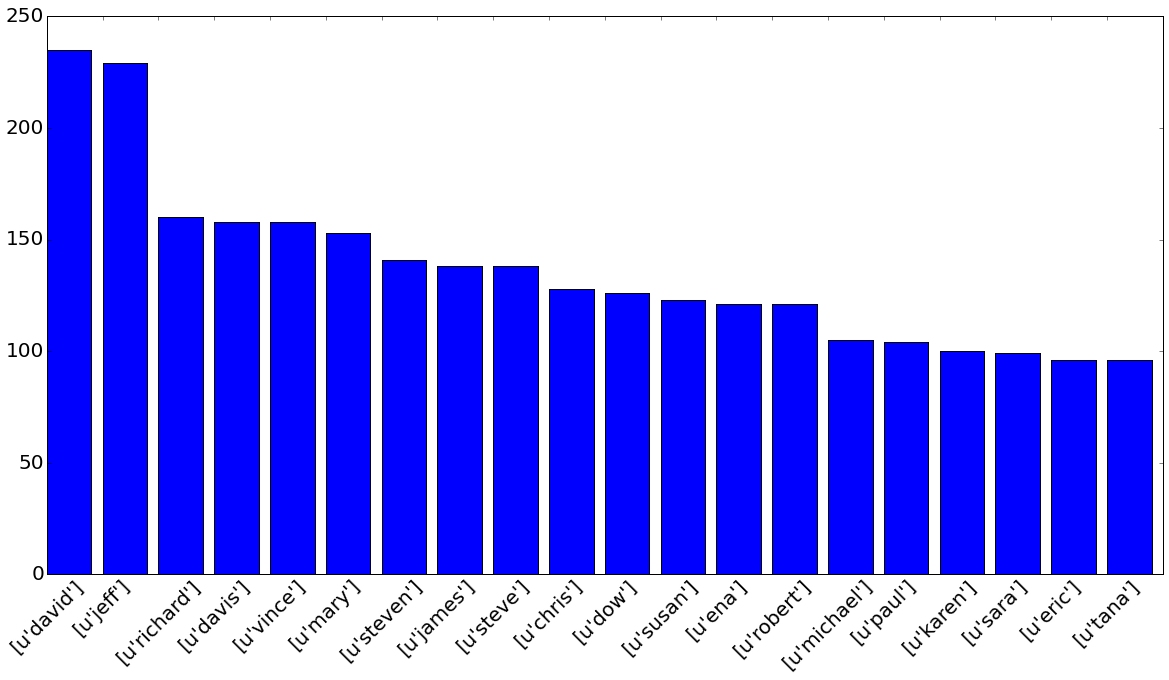

In [19]:
plt.figure(figsize=(20,10))
plt.bar(range(len(Per_numbers)), Per_numbers)
plt.xticks(range(len(Per_values)), Per_values, size = 20 , rotation=45)
plt.yticks(size = 20)
plt.show()

David Delainey - Enron Executive

Jeffrey Keith "Jeff" Skilling -CEO

Richard Kinder - Enron Executive

In [20]:
Loc_numbers = [d['I-LOC'][i][1] for i in range(len(d['I-LOC']))]
Loc_values = [d['I-LOC'][i][0] for i in range(len(d['I-LOC']))]

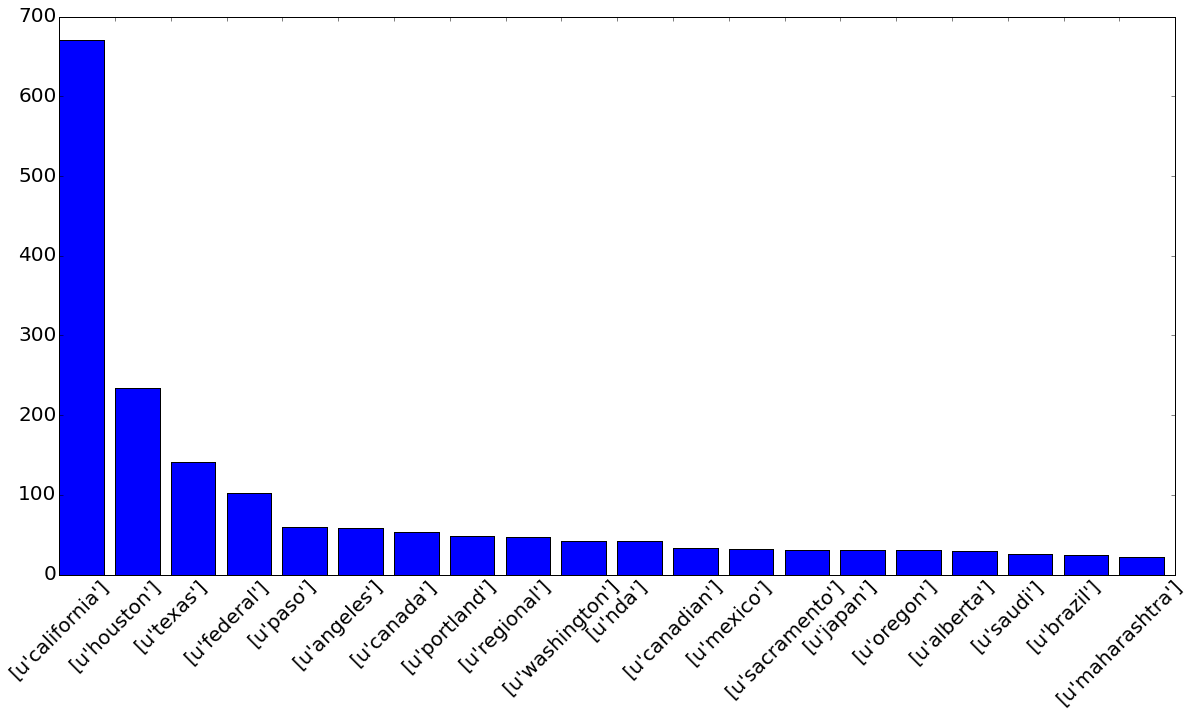

In [21]:
plt.figure(figsize=(20,10))
plt.bar(range(len(Loc_numbers)), Loc_numbers)
plt.xticks(range(len(Loc_values)), Loc_values, size = 20 , rotation=45)
plt.yticks(size = 20)
plt.show()

In [22]:
Org_numbers = [d['I-ORG'][i][1] for i in range(len(d['I-ORG']))]
Org_values = [d['I-ORG'][i][0] for i in range(len(d['I-ORG']))]

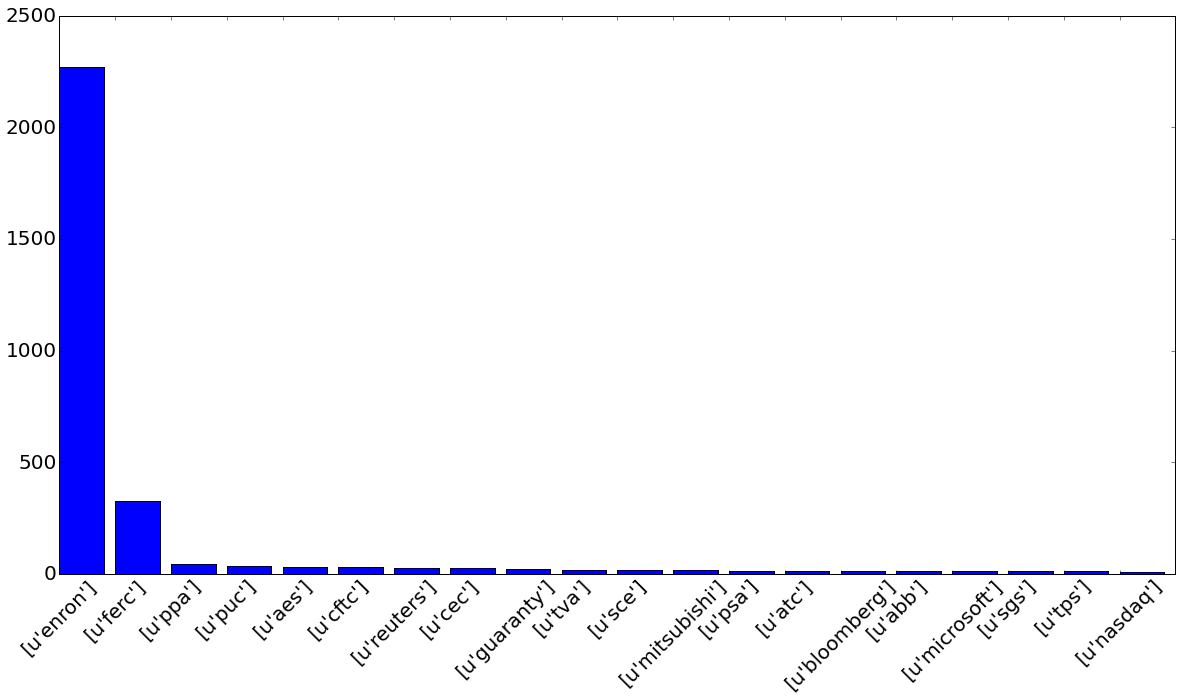

In [23]:
plt.figure(figsize=(20,10))
plt.bar(range(len(Org_numbers)), Org_numbers)
plt.xticks(range(len(Org_values)), Org_values, size = 20 , rotation=45)
plt.yticks(size = 20)
plt.show()

In [24]:
clean_enron = Counter(pos_tag)

In [25]:
clean_enron.most_common()[:20]

[(('enron', 'NN'), 1626),
 (('power', 'NN'), 1182),
 (('gas', 'NN'), 834),
 (('market', 'NN'), 822),
 (('energy', 'NN'), 781),
 (('price', 'NN'), 537),
 (('electricity', 'NN'), 501),
 (('state', 'NN'), 448),
 (('california', 'NN'), 418),
 (('information', 'NN'), 411),
 (('2001', 'CD'), 406),
 (('prices', 'NNS'), 391),
 (('time', 'NN'), 368),
 (('2000', 'CD'), 354),
 (('agreement', 'NN'), 326),
 (('company', 'NN'), 308),
 (('markets', 'NNS'), 269),
 (('trading', 'NN'), 263),
 (('business', 'NN'), 251),
 (('mark', 'NN'), 246)]

In [26]:
blob = TextBlob(str(enron["email"][1]), analyzer=NaiveBayesAnalyzer())
blob.sentiment

Sentiment(classification='pos', p_pos=0.9999999886581485, p_neg=1.1341874328164924e-08)

In [27]:
for i in useless_words:
    clean = clean_enron1.str.replace(str(i), '')

In [28]:
for i in stop:
    clean = clean_enron1.str.replace(str(i), '')

In [29]:
x = clean
y = enron['responsive']
count_vect = CountVectorizer(stop_words='english',analyzer='word')
X_train_counts = count_vect.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(X_train_counts,y)
clf = LogisticRegression().fit(X_train, y_train)
predict =clf.predict(X_test)

print "Score: %s" % clf.score(X_test,y_test)
print "F1 Score: %s" % f1_score(y_test,predict)
print "Precision: %s" % precision_score(y_test,predict)
print "Recall: %s" % recall_score(y_test,predict)
print "Confusion Matrix:"
print confusion_matrix(y_test,predict)
matrix = confusion_matrix(y_test,predict)


Score: 0.911214953271
F1 Score: 0.536585365854
Precision: 0.647058823529
Recall: 0.458333333333
Confusion Matrix:
[[184   6]
 [ 13  11]]


Confusion matrix, without normalization
[[184   6]
 [ 13  11]]


/Users/user/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


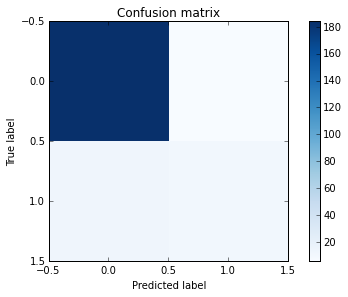

In [30]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_test, predict)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

plt.show()

ROC AUC: 0.81


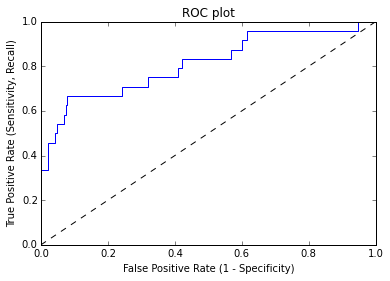

In [31]:
probabilities = clf.predict_proba(X_test)[:, 1]

fpr,tpr,threshold = roc_curve(y_test,probabilities)
roc_auc = auc(fpr, tpr)
print "ROC AUC: %0.2f" % roc_auc

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC plot")
plt.show()

In [32]:
kf = KFold(X_train_counts.shape[0], n_folds = 20, shuffle = True)
F1 = []
Acc = []

#pre = tp/(tp+fp)
#recall = tp/()

for train_index, test_index in kf:
    X_train, X_test = X_train_counts[train_index],X_train_counts[test_index]
    y_train, y_test = y[train_index],y[test_index]
    
    clf =MultinomialNB().fit(X_train, y_train)
    predict =clf.predict(X_test)
    Acc.append(clf.score(X_test,y_test))
    F1.append(f1_score(y_test,predict))

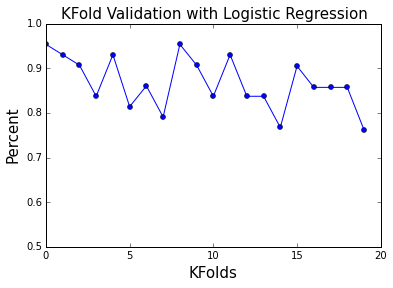

In [33]:
plt.plot(range(len(Acc)),Acc , marker = 'o', markersize = 5)
plt.xlabel("KFolds" , size = 15)
plt.ylabel("Percent", size = 15)
plt.ylim(0.5,1)
plt.title("KFold Validation with Logistic Regression", size = 15)
plt.show()

In [34]:
print np.mean(Acc)

0.866555924695


In [35]:
X_train_counts = count_vect.fit_transform(no_stop_words)

In [36]:
vocab = count_vect.get_feature_names()
nmf = NMF(n_components = 5, random_state = 1)
nmf.fit(X_train_counts)

NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
  n_components=5, nls_max_iter=2000, random_state=1, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [37]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [38]:
print(print_top_words(nmf, vocab, 20))

Topic #0:
enron gas california state time ferc business utilities lay houston report supply companies review jeff year capacity enrondevelopment transmission legal
Topic #1:
power gas california information prices agreement markets mark corp wholesale financial file rates project today richard vince date percent month
Topic #2:
energy electricity information 2001 2000 agreement company 27 credit david utilities customers changes group risk electric week meeting wholesale original
Topic #3:
market 2001 time ees 27 ferc trading company lay john david commission iso business review transmission comments meeting generation changes
Topic #4:
price state prices trading ferc markets john iso deal contracts jeff corp enrondevelopment companies year natural order demand legal contract
None


## Topic Ideas:

1) California's gas supply capacity

2) Wholesale financial information agreement

3) Energy electricity information between 2000-2001

4) Business Review

5) State prices

In [39]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(no_stop_words)
indices = np.argsort(vectorizer.idf_)
features = vectorizer.get_feature_names()
top_n = 20
top_features = [features[i] for i in indices[:top_n]] 

print top_features

[u'enron', u'power', u'gas', u'market', u'energy', u'california', u'electricity', u'price', u'state', u'information', u'2001', u'prices', u'time', u'2000', u'ees', u'ferc', u'agreement', u'company', u'trading', u'utilities']


In [ ]:
number = [1,1,1,2,1]
clean = []
for i in number:
    if i not in clean:
        clean.append(i)

Ferc - Federal Energy Regulatory Commission 

EES - Enron Energy Services